# Python spatial notebooks 1 : tour d'horizon du package rasterio

Cyril Bernard, fév 2022

## Objectifs

Le but de ce notebook est d'explorer les possibilités du package **rasterio**,
et de montrer comment faire les opérations les plus communes sur les rasters dans Python.

**Connaissances prérequises** : notions de base sur Python et le package numpy. Connaissances des formats raster.


## Données utilisées

- BD ALTI 25m des Pyrénées-Orientales (fichiers .asc)
- BD TOPO 2021 des Pyrénées-Orientales (fichiers .shp)
- IGN SCAN25 des Pyrénées-Orientales (fichiers .jp2)


## Sommaire

**[Partie 1 - opérations de base](#partie-1)**

- chargement des modules
- ouvrir un fichier raster, exemple 1 : un fichier '.jp2'
- lire les propriétés d'un raster
- ouvrir un fichier raster, exemple 2 : un fichier '.asc'
- lire les propriétés sous forme de dictionnaire avec meta et profile
- la matrice de transformation
- afficher les données (approche simple)
- charger les données d'1 bande raster dans 1 tableau numpy
- techniques de slicing appliquées aux données raster
- extraire une fenêtre avec le module windows
- fermer un raster

**[Partie 2 - traitements sur les rasters](#partie-2)**

- comment trouver les valeurs min et max d'1 bande, ainsi que d'autres informations sur les valeurs ?
- comment explorer la distribution des valeurs dans un raster ?
- comment utiliser numpy comme calculatrice raster ?
- comment enregistrer le résultat d'un calcul dans un nouveau fichier raster ?
- comment créer un jeu de données raster en mémoire ?
- comment fusionner des dalles rasters ?
- comment reprojeter un raster ?
- comment calculer les statistiques focales (fenêtre glissante sur les pixels) ?

**[Partie 3 - interactions vecteur - raster](#partie-3)**

- comment rastériser des polygones vectoriels ?
- comment masquer une partie d'un raster ?
- comment faire des statistiques zonales sur les polygones ?

**[Partie 4 - application sur une image Sentinel 2 (notebook suivant)](#partie-4)**

- lecture des bandes d'une image Sentinel-2 (Openhub Copernicus)
- comment extraire une fenêtre sans charger l'ensemble des données ?
- comment générer 1 raster multibandes à partir de 4 rasters monobandes ?
- comment calculer les quantiles avec les valeurs de chaque bande ?
- comment ajuster les valeurs pour visualiser l'image en RGB ?
- comment calculer un indice à partir des bandes d'1 raster ? Exemple : le NDVI
- comment lire les données et calculer un indice bloc par bloc ?


## 1ère partie : opérations de base<a class="anchor" id="partie-1"></a>

Dans cette 1ère partie, nous allons voir comment accéder et lire les caractéristiques d'un fichier raster dans **rasterio**.

### Chargement des packages

In [1]:
from os import listdir, makedirs
from os.path import join, exists

import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

print(f"Version rasterio : {rasterio.__version__}")
print(f"Version geopandas : {gpd.__version__}")


Version rasterio : 1.2.10
Version geopandas : 0.10.2


### Chemin d'accès des fichiers

In [2]:
# repertoire donnees
d_data = "data"

# donnees IGN
d_bdalti = join(d_data, "IGN", "BDALTIV2_MNT_25M_ASC_LAMB93_IGN69_D066")
d_bdtopo = join(d_data, "IGN", "BDT_3-0_SHP_LAMB93_D066-ED2021-03-15")
d_scan25 = join(d_data, "IGN", "SC25_TOUR_JP2-E100_LAMB93_D66")

# donnees Copernicus Sentinel 2
d_img_s2 = join(
    d_data, "Copernicus", 
    "S2A_MSIL2A_20210820T104021_N0301_R008_T31TDH_20210820T153044.SAFE",
    "GRANULE", "L2A_T31TDH_A032180_20210820T104404", "IMG_DATA", "R10m"
)

# le répertoire "output" servira à stocker les fichiers raster générés par les scripts
# il est créé, s'il n'existe pas déjà
d_output = "output"
if not exists(d_output):
    makedirs(d_output)

print("Chemin d'accès aux données :")
print(d_bdalti)
print(d_bdtopo)
print(d_scan25)
print ("Répertoire sortie :")
print(d_output)


Chemin d'accès aux données :
data\IGN\BDALTIV2_MNT_25M_ASC_LAMB93_IGN69_D066
data\IGN\BDT_3-0_SHP_LAMB93_D066-ED2021-03-15
data\IGN\SC25_TOUR_JP2-E100_LAMB93_D66
Répertoire sortie :
output


### Ouvrir un fichier raster <a class="anchor" id="lire-raster"></a>

La fonction `open` de rasterio nous permet d'ouvrir et accéder aux propriétés d'un fichier raster. 

Dans l'exemple suivant nous lui donnons le chemin et le nom d'un fichier avec l'extension '.jp2' (JPEG-2000). Il s'agit d'un extrait du SCAN25 des Pyrénées-Orientales : la carte topographique IGN 1/25000 scannée, sur une surface de 100 km2. 

Par défaut, le fichier raster est ouvert en **lecture seule** : la modification des propriétés et des valeurs contenues dans le fichier n'est pas permise. Nous verrons plus tard qu'il est possible d'ouvrir un fichier raster en écriture.

L'utilisation de la fonction `open` dans un bloc `with` permet d'ouvrir et fermer proprement le fichier raster.


In [3]:
# chemin d'acces complet
f_scan25 = join(d_scan25, "SC25_TOUR_0650_6170_L93_E100.jp2")

# lecture du raster
with rasterio.open(f_scan25) as ds_test:
    print("Objet", type(ds_test))
    # caractéristiques du raster
    print("Driver :", ds_test.driver)
    print("Nb de bandes :", ds_test.count)
    print("Resolution :", ds_test.res)
    print("BBox :", ds_test.bounds)
    print("Matrice transform :", ds_test.transform)
    print("Type :", ds_test.dtypes)
    print("Nodata value :", ds_test.nodata)
    print("CRS :", ds_test.crs)
    print("Nb de colonnes :", ds_test.width)
    print("Nb de lignes :", ds_test.height)

# état ouverture du dataset
print("Fermeture du fichier raster ?", ds_test.closed)


Objet <class 'rasterio.io.DatasetReader'>
Driver : JP2OpenJPEG
Nb de bandes : 3
Resolution : (2.5, 2.5)
BBox : BoundingBox(left=650000.0, bottom=6160000.0, right=660000.0, top=6170000.0)
Matrice transform : | 2.50, 0.00, 650000.00|
| 0.00,-2.50, 6170000.00|
| 0.00, 0.00, 1.00|
Type : ('uint8', 'uint8', 'uint8')
Nodata value : None
CRS : EPSG:2154
Nb de colonnes : 4000
Nb de lignes : 4000
Fermeture du fichier raster ? True


### Propriétés d'un jeu de données raster dans rasterio 

A partir de l'objet renvoyé (de type `DatasetReader`), il est possible de connaître les propriétés suivantes.

* Le **pilote GDAL**. Une chaîne correspondant au format de raster. Voir la colonne _short name_ dans ce tableau : <https://gdal.org/drivers/raster/index.html>. 

* Le **nombre de bandes**. Un nombre entier, par exemple 3 pour cette image qui contient 3 canaux R, G et B.

* La **résolution**. Un tuple avec 2 valeurs : c'est la taille d'un pixel un unité terrain. Ici, par exemple : 2.5 x 2.5 m. 

* L'**étendue** (bounding box). Un tuple avec 4 valeurs : les coordonnées x et y des bords dans le système de coordonnées du raster.

* La **matrice de transformation**. Cette matrice permet de 'convertir' les coordonnées pixels du raster en coordonnées géographiques. Voir la paragraphe suivant pour plus d'explications.

* Le **type numérique**. Un tuple, avec le type de chaque bande. Ici, nous avons des entiers non signés sur 8 bits : les valeurs seront comprises entre 0 et 255. La liste des types possibles est définie dans ce fichier : <https://github.com/rasterio/rasterio/blob/master/rasterio/dtypes.py>

* La valeur **NoData**. Une valeur qui représentera par convention les pixels sans données.

* Le **système de coordonnées de référence** (SCR ou CRS). Le système de coordonnées du raster : bien souvent, il est identifié par son code EPSG, ici 2154 = Lambert 93. Voir la définition du SCR sur cette page : <https://epsg.io/2154>.

* Le **nombre de lignes et de colonnes**. Ici, le raster s'apparente donc à un tableau de (4000 lignes X 4000 colonnes X 3 bandes) = 48000000 entiers entre 0 et 255. 

Dès que la fin du bloc `with` est atteinte, le jeu de données est fermé. Réouvrons le fichier pour continuer à le manipuler dans la suite du notebook.

In [4]:
# reouvrir le fichier
f_scan25 = join(d_scan25, "SC25_TOUR_0650_6170_L93_E100.jp2")
ds_scan25 = rasterio.open(f_scan25)


### Lire un fichier raster, autre exemple : un modèle numérique de terrain

Nous ouvrons un autre raster : cette fois il s'agit d'un extrait de la **BD ALTI** IGN, à la résolution de 25 m. Ce MNT (modèle numérique de terrain) contient les altitudes sur une zone de 625 km2. Le fichier porte l'extension '.asc' ; c'est un fichier ASCII qu'il est possible d'ouvrir avec un éditeur de texte, par exemple.

In [5]:
# chemin d'acces fichier
f_mnt = join(d_bdalti, "BDALTIV2_25M_FXX_0650_6175_MNT_LAMB93_IGN69.asc")

# acces au fichier en lecture
ds_mnt = rasterio.open(f_mnt)

print("Objet", type(ds_mnt))
# caractéristiques du raster
print("Driver :", ds_mnt.driver)
print("Nb de bandes :", ds_mnt.count)
print("Resolution :", ds_mnt.res)
print("BBox :", ds_mnt.bounds)
print("Matrice transform :", ds_mnt.transform)
print("Type :", ds_mnt.dtypes)
print("CRS :", ds_mnt.crs)
print("Nb de colonnes :", ds_mnt.width)
print("Nb de lignes :", ds_mnt.height)
print("Nodata value :", ds_mnt.nodata)


Objet <class 'rasterio.io.DatasetReader'>
Driver : AAIGrid
Nb de bandes : 1
Resolution : (25.0, 25.0)
BBox : BoundingBox(left=649987.5, bottom=6150012.5, right=674987.5, top=6175012.5)
Matrice transform : | 25.00, 0.00, 649987.50|
| 0.00,-25.00, 6175012.50|
| 0.00, 0.00, 1.00|
Type : ('float32',)
CRS : None
Nb de colonnes : 1000
Nb de lignes : 1000
Nodata value : -99999.0


Nous remarquons quelques particularités.

- le driver utilisé pour ce fichier est _AAIGrid_ dans la nomenclature GDAL, ce qui correspond au format Arc/Info ASCII Grid.
- le nombre de bande est 1 (1 valeur par pixel), ce qui est logique pour des altitudes.
- la résolution est de 25 mètres par pixel
- le type (ici, un tuple à 1 élément) est float32 : nombre flottant codé sur 32 bits.
- le CRS de ce fichier n'est pas explicitement défini (`None`). C'est propre au format '.asc' dont l'entête ne comporte pas cette information. En réalité, même s'il n'est pas explicitement spécifié, c'est bien le Lambert 93, tout comme dans l'exemple précédent.

### Profil d'un raster (dictionnaire)

On peut aussi récupérer les caractéristiques sous forme de dictionnaire avec la propriété `meta` du `DatasetReader`.

Cela est très utile quand on veut créer un nouveau fichier raster avec les mêmes caractéristiques d'un raster existant : comme on le verra plus tard, on peut **copier les caractéristiques** d'un raster à l'autre.

In [6]:
kwds_scan25 = ds_scan25.meta
kwds_scan25

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 4000,
 'height': 4000,
 'count': 3,
 'crs': CRS.from_epsg(2154),
 'transform': Affine(2.5, 0.0, 650000.0,
        0.0, -2.5, 6170000.0)}

In [7]:
kwds_mnt = ds_mnt.meta
kwds_mnt

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 1000,
 'height': 1000,
 'count': 1,
 'crs': None,
 'transform': Affine(25.0, 0.0, 649987.5,
        0.0, -25.0, 6175012.5)}

**Remarque** : il existe une autre propriété `profile`, très similaire à `meta`, et qui renvoie aussi un dictionnaire, avec quelques infos supplémentaires telles que la présence et la dimension des blocs dans un fichier raster. 

Pour simplifier, nous n'utiliserons que `meta` dans la suite de ce notebook.

In [8]:
prfl_scan25 = ds_scan25.profile
prfl_scan25

{'driver': 'JP2OpenJPEG', 'dtype': 'uint8', 'nodata': None, 'width': 4000, 'height': 4000, 'count': 3, 'crs': CRS.from_epsg(2154), 'transform': Affine(2.5, 0.0, 650000.0,
       0.0, -2.5, 6170000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}

### La matrice de transformation

**... où comment passer des coordonnées de l'image aux coordonnées de terrain.** 

La matrice de transformation à 9 valeurs, définie par la propriété `transform`, est importante. Nous la retrouverons dans rasterio au moment d'afficher les données raster, ou de reprojeter un raster.

Un jeu de données raster, par exemple notre MNT, peut être considéré comme un tableau en 2D dont l'élément (0,0) est le pixel en haut à gauche.

La multiplication des coordonnées pixels par la matrice de transformation permet de trouver les coordonnées géographiques d'un point (dans le système Lambert 93), par exemple le coin en haut à gauche. 


In [9]:
# matrice de transformation du MNT
transform = ds_mnt.transform
print("Matrice de transformation du MNT")
print(transform)
# coin en haut à gauche
img_top_left = (0,0)
# coin en bas à droite
img_bottom_right = (1000,1000)
# coin Lambert 93 en haut à gauche
l93_top_left = transform * img_top_left
# coin Lambert 93 en bas à droite
l93_bottom_right = transform * img_bottom_right
print(f"Coordonnées du pixel {img_top_left} en Lambert 93 : {l93_top_left}")
print(f"Coordonnées du pixel {img_bottom_right} en Lambert 93 : {l93_bottom_right}")


Matrice de transformation du MNT
| 25.00, 0.00, 649987.50|
| 0.00,-25.00, 6175012.50|
| 0.00, 0.00, 1.00|
Coordonnées du pixel (0, 0) en Lambert 93 : (649987.5, 6175012.5)
Coordonnées du pixel (1000, 1000) en Lambert 93 : (674987.5, 6150012.5)


L'image suivante, issue de la page <https://fr.wikipedia.org/wiki/World_file>, illustre le calcul appliqué pour passer de l'image aux coordonnées de terrain.

![Exemple de transformation](Exemple_de_transformation.jpg)

Crédit : _Samuel Morissette, [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), via Wikimedia Commons_

#### Les méthodes `xy` et `index`

La méthode `xy` permet aussi de convertir les coordonnées pixels en coordonnées géographiques. Elle prend 2 paramètres : ligne, colonne. Mais attention ! elle renvoie la position du **centre du pixel**.

A l'inverse, la méthode `index` permet de convertir les coordonnées géographiques en coordonnées pixel. Elle renvoie un tuple (ligne, colonne).

In [10]:
# coord en pixel (ligne, colonne) -> coord géo du centre du pixel (x, y lambert 93)
print(ds_mnt.xy(0, 0))
# coord géo (x, y lambert 93) -> coord pixel (ligne, colonne)
print(ds_mnt.index(650200.0, 6174900.0))

(650000.0, 6175000.0)
(4, 8)


### Afficher des données (approche simple)

La fonction `show` du module `rasterio.plot` affiche les donnéees du raster,
avec le système de coordonnées des données d'origine (ici, le Lambert 93).
Elle renvoie un objet `axes`.

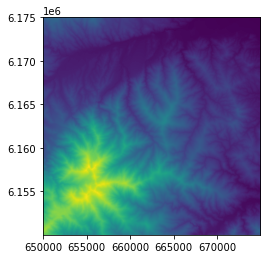

In [11]:
# afficher le relief du MNT 25 m (dalle du Canigou)
from rasterio.plot import show
ax = show(ds_mnt)

Remarquez sur les bords de la carte des graduations (_ticks_) correspondant aux coordonnées en Lambert 93.

Sur un raster à 1 bande avec des valeurs continues comme ce MNT, la palette _viridis_ est appliquée par défaut.

Avec un raster à 3 bandes comme la carte scannée, on obtient une composition colorée RGB.

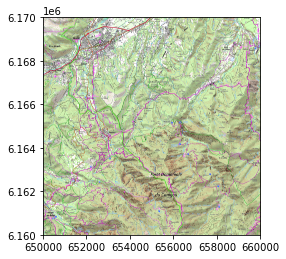

<AxesSubplot:>

In [12]:
# afficher la dalle de Scan 25
show(ds_scan25)

### Charger les valeurs du raster dans un tableau array

Pour accéder aux données contenues dans un raster, on les charge en mémoire sous la forme d'un tableau numpy, avec la méthode `read`. L'objet obtenu ainsi est de type `ndarray`.

- Si on passe `read` à la méthode un index de la bande (exemple : index 1 pour la bande 1), on obtient un tableau à 2 dimensions.
- Si on ne spécifie pas d'index, on obtient un tableau à 3 dimensions. Dans ce cas, les 3 axes sont les suivants : **(bandes, lignes, colonnes)**.


In [13]:
# lire les données dans numpy en 3D : toutes les bandes (même s'il n'y en a qu'1 !)
values_mnt = ds_mnt.read()
print(f"Shape all : {np.shape(values_mnt)}")

# lire les données dans numpy en 2D: bande 1
values_mnt1 = ds_mnt.read(1)
print(f"Shape B1 : {np.shape(values_mnt1)}")

# aperçu des données (ici 2D)
values_mnt1


Shape all : (1, 1000, 1000)
Shape B1 : (1000, 1000)


array([[ 924.3 ,  910.8 ,  898.  , ...,  120.74,  120.61,  120.71],
       [ 920.6 ,  909.6 ,  896.6 , ...,  120.91,  120.89,  120.62],
       [ 911.7 ,  903.4 ,  895.  , ...,  121.05,  120.87,  120.81],
       ...,
       [2225.2 , 2230.6 , 2224.  , ...,  887.  ,  897.2 ,  910.  ],
       [2216.9 , 2226.  , 2234.1 , ...,  876.4 ,  887.2 ,  900.1 ],
       [2203.1 , 2197.8 , 2188.8 , ...,  868.3 ,  880.1 ,  893.  ]],
      dtype=float32)

La méthode `read` lit les données du raster en commençant par le pixel en haut à gauche. Puisque dans **numpy**, les cellules des tableau sont indexées à partir de 0, l'altitude du pixel en haut à gauche est donc obtenue ainsi :

In [14]:
# altitude du pixel (0,0) = pixel 1ere ligne 1ere colonne
print (values_mnt1[0,0])

924.3


### Utilisation du slicing pour accéder aux valeurs du raster

In [15]:
# chargeons les valeurs du Scan25
values_scan25 = ds_scan25.read()

# affichons les caractéristiques du tableau obtenu
print(f"objet : {type(values_scan25)}")
print(f"ndim : {values_scan25.ndim}")
print(f"shape : {values_scan25.shape}")
print(f"size : {values_scan25.size}")
print(f"dtype : {values_scan25.dtype}")


objet : <class 'numpy.ndarray'>
ndim : 3
shape : (3, 4000, 4000)
size : 48000000
dtype : uint8


Quand on utilise la méthode `read` sans préciser l'index de la bande, nous obtenons un tableau numpy avec 3 axes : 

- l'axe 0 : bandes du raster
- l'axe 1 : lignes
- l'axe 2 : colonnes

Pour trouver les valeurs RGB du pixel en haut à gauche de la dalle Scan25, nous appliquons donc le code suivant :

In [16]:
# toutes les valeurs pour l'axe des bandes
values_scan25[:, 0, 0]

array([165, 253, 121], dtype=uint8)

Pour trouver les valeurs RGB des 250 lignes x 350 colonnes à partie du haut à gauche :

In [17]:
rgb_l250_c350 = values_scan25[:, 0:250, 0:350]
rgb_l250_c350.shape

(3, 250, 350)

**Utiliser l'indexation pour changer l'ordre des bandes**. On peut changer l'ordre des bandes de la manière suivante :

In [18]:
# par exemple on veut changer l'ordre initial "RGB" en "BGR"
values_bgr = values_scan25[(2,1,0), :, :]
values_bgr

array([[[121, 112, 117, ..., 178,  61, 167],
        [159,  95, 253, ..., 255, 255, 255],
        [159,  95, 253, ..., 255, 255, 255],
        ...,
        [155, 157, 158, ...,  90, 147, 164],
        [120, 156, 159, ...,  89, 104, 164],
        [ 87,  88, 103, ...,  98,  90, 164]],

       [[253, 203, 140, ..., 199, 131, 219],
        [253, 253, 253, ..., 255, 255, 255],
        [253, 253, 253, ..., 255, 255, 255],
        ...,
        [213, 215, 217, ..., 112, 200, 225],
        [160, 213, 218, ..., 112, 134, 225],
        [110, 111, 136, ..., 125, 114, 225]],

       [[165, 179, 207, ..., 185,  84, 185],
        [190, 148, 253, ..., 255, 255, 255],
        [190, 148, 253, ..., 255, 255, 255],
        ...,
        [175, 176, 178, ..., 179, 184, 184],
        [172, 177, 179, ..., 178, 181, 184],
        [172, 174, 175, ..., 179, 179, 184]]], dtype=uint8)

### Extraire une fenêtre dans un raster avec Windows

Pour extraire une partie d'un raster **sans charger en mémoire l'ensemble du fichier**, utiliser la fonction `Windows` avec une fenêtre définie en pixels.

2 syntaxes sont possibles :

    Window(col_off, row_off, width, height)
    
ou bien

    Window.from_slices((row_start, row_stop), (col_start, col_stop))

Voir aussi le paragraphe sur la **lecture par blocs** dans la partie suivante.

In [19]:
from rasterio.windows import Window
win = Window(0, 0, 350, 250)
values_win = ds_scan25.read(window=win)
values_win.shape

(3, 250, 350)

In [20]:
ds_scan25.transform

Affine(2.5, 0.0, 650000.0,
       0.0, -2.5, 6170000.0)

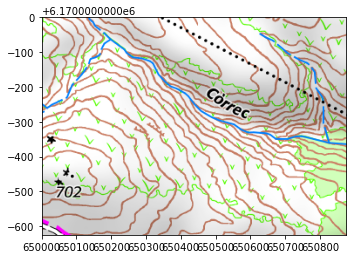

<AxesSubplot:>

In [21]:
# afficher la partie découpée avec rasterio.plot.show ...
# il faut calculer la fonction de transformation de la partie découpée
win_transform = rasterio.windows.transform(win, ds_scan25.transform)
show(values_win, transform=win_transform)

### Comment les pixels "sans données" sont-ils gérés ?


### Fermer un raster

In [22]:
ds_scan25.close()

### A retenir

Qu'avons nous vu dans cette 1ère partie ?

- nous avons utilisé 3 modules : **rasterio** (le module de base) et **rasterio.windows** (pour les fenêtres), ainsi que **numpy** dont rasterio dépend.
- la fonction `open` permet d'accéder à un fichier raster en mode lecture ou en mode écriture
- en mode lecture des données, quand tout se passe bien, la fonction `open` renvoie un objet de classe `DatasetReader` qui permet à son tour d'accéder aux propriétés du raster, ou aux données
- les propriétés les plus utiles sont `driver`, `transform`, `crs`, `dtypes`, `count`, `width`, `height`, `res`, `bounds`
- avec `meta`, on obtient les propriétés d'un raster sous la forme d'1 dictionnaire. Cela est bien utile pour créer un nouveau raster avec les propriétés d'un raster existant
- avec `read`, on peut accéder aux valeurs des pixels sous la forme d'1 tableau numpy : soit les données de toutes les bandes, soit les données d'1 bande particulière
- la propriété `transform` est importante : il s'agit des coefficients du polynôme qui permettent de passer des coordonnées du tableau numpy (lignes, colonnes) aux coordonnées géographiques (X, Y)
- il est possible de lire les données d'une fenêtre définie avec `Windows`. Cela évite de charger toutes les données en mémoire


## 2ème partie : traitements sur les rasters<a class="anchor" id="partie-2"></a>

### Comment rechercher les valeurs minimum et maximum dans un raster ?

In [23]:
# altitude min et max dans le MNT
values_mnt1 = ds_mnt.read(1)
np.amin(values_mnt1), np.amax(values_mnt1)

(120.61, 2779.0)

### Comment rechercher les coordonnées des pixels min et max ?

`argmax` renvoie l'indice de la valeur maximale (en partant de la cellule 0,0 qui est en haut à gauche de la matrice).
`unravel_index` permet ici de trouver la ligne et la colonne de l'indice précédemment obtenu.


In [24]:
# index 1D du pixel avec l'altitude max
indmax1d = np.argmax(values_mnt1, axis=None)
print("Index max :", indmax1d)
# index 2D (ligne, colonne) du max
indmax2d = np.unravel_index(indmax1d, values_mnt1.shape)
print("Ligne / colonne max :", indmax2d)
xymax = ds_mnt.xy(indmax2d[0], indmax2d[1])
print("Coord. Lambert 93 :", xymax)


Index max : 686211
Ligne / colonne max : (686, 211)
Coord. Lambert 93 : (655275.0, 6157850.0)


### Comment visualiser la distribution des pixels

La fonction `show_hist` du module **rasterio.plot** avec assez similaire à `hist` dans matplotlib.

Le paramètre `bins` peut être un nombre de barres, ou bien les limites des barres.

TODO : masquer la légende


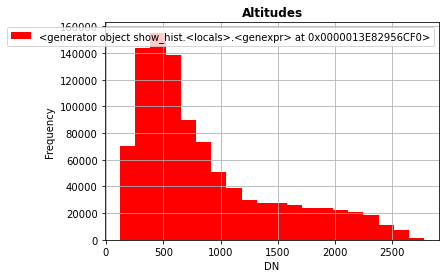

In [25]:
# avec un nombre de barres = 0
from rasterio.plot import show_hist
show_hist(ds_mnt, bins=20, title="Altitudes")


[   0.  250.  500.  750. 1000. 1250. 1500. 1750. 2000. 2250. 2500. 2750.
 3000.]


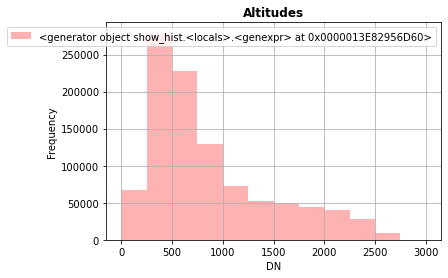

In [26]:
# définir 12 barres entre 0 et 3000 m, tous les 250 m
bins_alti = np.linspace(0,3000,13)
print(bins_alti)
show_hist(ds_mnt, bins=bins_alti, title="Altitudes", histtype="stepfilled", alpha=0.3)

### Comment utiliser numpy comme calculatrice raster

Recherchons les pixels situés à une altitude >= 1000 m. On utilise un opérateur de comparaison qui renvoie un tableau numpy de booléens.

In [27]:
# recherche altitude > 2000 
values_mnt1 = ds_mnt.read(1)
altitest = (values_mnt1 >= 1000)
altitest

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

Nous pouvons ensuite afficher ce tableau. Les cellules du tableau égales à VRAI s'affichent en **jaune**.

TODO : compter le nb de pixel = VRAI, en déduire la surface > 1000 m sur ce raster.

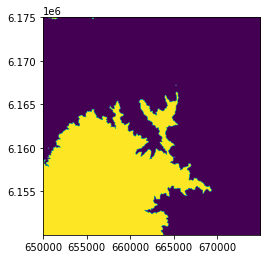

<AxesSubplot:>

In [28]:
# afficher les pixels > 1000 m (en jaune)
show(altitest, transform = ds_mnt.transform)

**Remarque** : le tableau numpy altitest n'a pas d'infos relatives au géoréférencement, c'est pourquoi nous passer la _matrice de transformation_ pour avoir les coordonnées géographiques des pixels. Nous reviendrons dessus dans la partie _Visualisation des données_.

**Compter le nombre de pixels `True`**. Pour compter le nombre de pixels >= 1000 m, il suffit ici de calculer le total des valeurs, sachant que Vrai équivaut à 1. 

In [29]:
# nb pixels >= 1000m
nb_vrai = np.sum(altitest)
# surface totale >= 1000 m ?
# 1 pixel = (0.25 * 0.25) ha
print(f"Surface totale >= 1000m. : {nb_vrai * (0.25*0.25)} ha")

Surface totale >= 1000m. : 18538.0 ha


### Comment sauvegarder un tableau numpy en GeoTIFF

Pour réassocier les données de géoréférencement à notre tableau de booléens, nous récupérons le `profile` du raster MNT original. **Dans ce profil, nous modifions juste 3 valeurs** : 

- le format de sortie (GTiff à la place de AAIGrid, voir liste des drivers GDAL)
- le type de données (uint8 à la place de float32)
- la valeur associée à NoData (255), bien que ce ne soit pas une obligation
- le CRS (Lambert-93, EPSG:2154), car il n'était pas défini dans le fichier en entrée

Remarque : le format GeoTIFF n'accepte pas le type _Booléen_. C'est pourquoi nous choisissons pour le raster en sortie le type _Entier non signé sur 8 bits_.

In [30]:
# CRS Lambert 93 () 
from rasterio.crs import CRS
crs_l93 = CRS.from_epsg(2154)

dst_kwds = ds_mnt.meta.copy()
dst_kwds.update({
    'crs': crs_l93,
    'driver': "GTiff",
    'dtype': "uint8",
    'nodata': 255
})
dst_kwds

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255,
 'width': 1000,
 'height': 1000,
 'count': 1,
 'crs': CRS.from_epsg(2154),
 'transform': Affine(25.0, 0.0, 649987.5,
        0.0, -25.0, 6175012.5)}

Puis **nous ouvrons le fichier de sortie en écriture** (ce qui revient à le créer) en passant le profil en paramètre. Et nous écrivons le tableau de booléens dans la bande 1.

In [31]:
f_output = join(d_output, 'altitest.tif')

with rasterio.open(f_output, 'w', **dst_kwds) as dst_dataset:
    dst_dataset.write(altitest, 1)

### Comment créer un nouveau raster en mémoire (in-memory files) ?

Pour créer un nouveau _dataset raster_ sans générer de nouveau fichier, une solution est d'utiliser la classe `MemoryFile` du module **rasterio.io**.  Cf <https://rasterio.readthedocs.io/en/latest/topics/memory-files.html>.

Ainsi, pour reprendre l'exemple précédent, nous pouvons créer un dataset raster à partir de notre tableau de booléens.

In [32]:
from rasterio.io import MemoryFile

with MemoryFile() as memfile:
    with memfile.open(**dst_kwds) as dataset:
        dataset.write(altitest, 1)


### Comment fusionner des rasters ?

Fusionner des rasters se fait avec la fonction `merge` du module **rasterio.merge**, en passant une liste de datasets raster.

Dans l'exemple suivant, nous fusionnons 8 dalles de la BD ALTI en un seul dataset, au format GeoTIFF. 

In [33]:
# fichiers en entrée: lister les fichiers .asc dans le répertoire
asc_files = [f for f in listdir(d_bdalti) if f.endswith(".asc")]
asc_files

['BDALTIV2_25M_FXX_0625_6175_MNT_LAMB93_IGN69.asc',
 'BDALTIV2_25M_FXX_0625_6200_MNT_LAMB93_IGN69.asc',
 'BDALTIV2_25M_FXX_0650_6175_MNT_LAMB93_IGN69.asc',
 'BDALTIV2_25M_FXX_0650_6200_MNT_LAMB93_IGN69.asc',
 'BDALTIV2_25M_FXX_0675_6175_MNT_LAMB93_IGN69.asc',
 'BDALTIV2_25M_FXX_0675_6200_MNT_LAMB93_IGN69.asc',
 'BDALTIV2_25M_FXX_0700_6175_MNT_LAMB93_IGN69.asc',
 'BDALTIV2_25M_FXX_0700_6200_MNT_LAMB93_IGN69.asc']

#### Exemple 1 : générer un fichier GeoTIFF en sortie

Nous passons à la fonction `merge` la liste des fichiers rasters à fusionner (avec le chemin complet), le chemin du fichier en sortie ainsi qu'un dictionnaire avec les paramètres de création du fichier de sortie. N'oublions pas d'associer le CRS Lambert 93.

In [34]:
%%time
# exemple 1 : fichier en sortie
from rasterio.merge import merge
f_liste = [join(d_bdalti, x) for x in asc_files]
f_merged = join(d_output, "merged.tif")
kwds_merged = {
    'driver': 'GTiff',
    'crs': CRS.from_epsg(2154)
}
# exemple : fusionner les 4 rasters dans un nouveau fichier "output/merged.tif"
merged = merge(f_liste, dst_path=f_merged, dst_kwds=kwds_merged)
merged

CPU times: total: 3.36 s
Wall time: 3.37 s


**Remarque** : si on spécifie un fichier en sortie, la fonction `merge` renvoie **None**.


#### Exemple 2 : générer un tableau numpy en sortie

Si on ne spécifie pas de fichier, la valeur de retour est un tuple avec un tableau `ndarray` et une matrice de transformation.


In [35]:
# exemple 2 : tableau numpy en sortie
merged_values, merged_transform = merge(f_liste)
print(merged_transform)
print(merged_values.shape)

| 25.00, 0.00, 624987.50|
| 0.00,-25.00, 6200012.50|
| 0.00, 0.00, 1.00|
(1, 2000, 4000)


### Comment reprojeter un raster ?

La fonction `reproject` du module **rasterio.warp** permet de convertir les données d'un raster d'un CRS vers un autre. Lorsqu'on effectue une telle opération, la géométrie des pixels change et il faut nécessairement passer par une **réechantillonage** des pixels.

Pour reprojeter un raster d'un système de coordonnées à un autre, nous avons besoin des informations suivantes pour le **raster de départ** et le **raster d'arrivée** :

- les **systèmes de coordonnées** (CRS) des rasters
- les **matrices de transformation** (transform) des rasters
- la **méthode de réechantillonnage** choisie (exemple : plus proche voisin, bilinéaire, bicubique)

La fonction `reproject` du module **rasterio.warp** peut d'ailleurs être utilisée de 2 manières :

1. avec les **bandes d'un raster**. Dans ce cas, la fonction va lire le CRS et la matrice de transformation directement dans le raster de départ et d'arrivée. Il faut donc **que le CRS soit explicitement défini** dans le fichier de départ, sinon cela échouera. Si le raster à reprojeter compte N bandes, il faudra appliquer N fois la fonction `reproject`, pour chaque bande.
2. avec des **tableaux numpy**. Dans cas, il faut spécifier le CRS et la matrice de transformation, aussi bien pour les données de départ que pour les données d'arrivée. 


#### Exemple 1 : avec les bandes d'un raster

Nous partons du fichier `merged.tif` précédemment créé. Ce raster en Lambert 93, comporte les altitudes sur une zone de 2000 lignes x 4000 colonnes, avec une résolution de 25 m.

Essayons de reprojeter ce raster en UTM 31N WGS84 (EPSG:32631) en gardant une résolution de 25 m. 

Nous pouvons créer en sortie un raster au format GeoTIFF, mais quel sera la matrice de transformation (propriété `transform`) pour ce nouveau fichier ?

- si on dispose d'une image de référence (exemple : une image Sentinel 2 dans le système UTM 31N) sur laquelle on veut aligner les pixels, en adoptant la même étendue et la résolution, on peut recopier les propriétés de cette image avec `meta`
- on peut laisser rasterio calculer la matrice de transformation "optimale" avec la fonction `calculate_default_transform` (exemple 1A ci-dessous)
- on peut aussi définir soi-même une matrice de transformation avec la fonction `Affine`, si on connaît la résolution et les coordonnées en haut à gauche du raster à créer (exemple 1B ci-dessous)


In [36]:
# exemple 1A : calculer matrice de transformation
from rasterio.warp import calculate_default_transform, reproject, Resampling

# définir CRS source et destination
src_crs = CRS.from_epsg(2154)
dst_crs = CRS.from_epsg(32631)

# ouvrir le fichier merged.tif (DatasetReader) et lire propriétés
ds_merged = rasterio.open(f_merged)

# calculer matrice transformation du raster destination
transform, width, height = calculate_default_transform(
    ds_merged.crs, dst_crs, 
    ds_merged.width, ds_merged.height,
    *ds_merged.bounds, resolution=25)
print("matrice transform :")
print(transform)
print("nb colonnes x lignes :", width, height)


matrice transform :
| 25.00, 0.00, 425090.73|
| 0.00,-25.00, 4749658.61|
| 0.00, 0.00, 1.00|
nb colonnes x lignes : 3995 1998


Essayons dans l'exemple 1B de définir une matrice de transformation avec des coordonnées "qui tombent juste" pour les bords du raster en sortie.

In [37]:
# exemple 1B : définir matrice de transformation
from rasterio import Affine as A
# nb ligne, colonnes
dst_shape = height, width = (2000, 4000)
dst_x_ul, dst_y_ul = (425000.0, 4750000.0)
dst_res  = 25.0
pretty_transform = A.translation(dst_x_ul, dst_y_ul) * A.scale(dst_res, -dst_res)

print("matrice transform :")
print(pretty_transform)
print("nb colonnes x lignes :", width, height)

matrice transform :
| 25.00, 0.00, 425000.00|
| 0.00,-25.00, 4750000.00|
| 0.00, 0.00, 1.00|
nb colonnes x lignes : 4000 2000


Nous sommes prêt à créer le nouveau raster `warped1.tif`.

In [38]:
%%time
# exemple 1, suite : reprojection des bandes de fichier à fichier
# définir propriétés du raster de sortie : crs, transform, width, height
src_kwds = ds_merged.meta
wrp_kwds = src_kwds.copy()
wrp_kwds.update({
    'crs': CRS.from_epsg(32631),
    'transform': pretty_transform,
    'width': width,
    'height': height
})
# chemin du raster de sortie
f_warped1 = join(d_output, "warped1.tif")

# creation du raster de sortie
with rasterio.open(f_warped1, 'w', **wrp_kwds) as ds_warped1:
    # reprojeter + ecrire la bande 1
    reproject(
        source=rasterio.band(ds_merged, 1),
        destination=rasterio.band(ds_warped1, 1),
        resampling=Resampling.bilinear)


CPU times: total: 438 ms
Wall time: 436 ms


#### Exemple 2 : générer un tableau numpy en sortie

Dans cet exemple nous partons du tableau numpy généré précédemment : `merged_values` que nous allons reprojeter dans un nouveau tableau numpy. 

On note que sur les bords du raster reprojeté en UTM sont apparus des pixels avec la valeur -9999 : ce sont des pixels _sans données_.


In [39]:
%%time
# exemple 2 : reprojection de tableau à tableau
# créer un tableau vierge
warped_values = np.zeros((height, width), np.float32)

reproject(
    source=merged_values,
    destination=warped_values,
    src_transform=merged_transform,
    src_crs=src_crs,
    dst_transform=pretty_transform,
    dst_crs=dst_crs,
    dst_nodata=-9999.0,
    resampling=Resampling.bilinear)

CPU times: total: 391 ms
Wall time: 391 ms


(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ...,     0., -9999., -9999.],
        [-9999., -9999., -9999., ...,     0., -9999., -9999.],
        [-9999., -9999., -9999., ...,     0., -9999., -9999.]],
       dtype=float32),
 Affine(25.0, 0.0, 425000.0,
        0.0, -25.0, 4750000.0))

<class 'numpy.ndarray'>


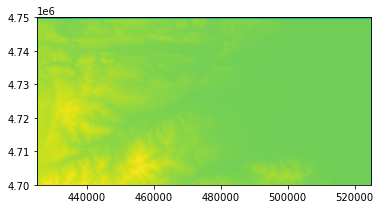

<AxesSubplot:>

In [40]:
# afficher le résultat
print(type(warped_values))
show(warped_values, transform=pretty_transform)

### Comment gérer les pixels sans données, un exemple

Dans l'exemple qui précéde, des pixels "sans données" sont observés sur les bords du raster. Dans les métadonnées du raster figure une valeur **NoData** qui par convention est utilisée pour les pixels sans données : ici, -9999. 

Un logiciel tel que QGIS, grâce aux métadonnées du raster, interprétera la valeur -9999 comme "absence de valeur". Qu'en est-il de Python et de rasterio ?

Dans Python, `Nan` (_Not a number_) est généralement utilisée pour répresenter les valeurs indéfinies.

Dans numpy, on utilise aussi les tableaux masqués ou **masked array** qui consistent à associer **un tableau de booléen utilisé comme masque** à un tableau numpy habituel.

Les masked array sont mis en oeuvre avec le module **numpy.ma** ; on peut aussi les employer dans **rasterio** en appelant la fonction `read` avec le paramètre `masked`.


In [41]:
# dans le graphique précédent ainsi que la ligne qui suit 
# (recherche du minimum) on voit que la valeur -9999 n'est pas considérée
# comme "valeur indéterminée"
min_value = np.min(warped_values)
print ("Val min :", min_value)

# et si on charge les valeurs en tant que masquées ?
with rasterio.open(f_warped1, 'r') as ds_warped1:
    warped_values1 = ds_warped1.read(1, masked=True)
    
warped_values1  


Val min : -9999.0


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., 0.0, --, --],
        [--, --, --, ..., 0.0, --, --],
        [--, --, --, ..., 0.0, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False,  True,  True]],
  fill_value=-99999.0,
  dtype=float32)

Un **masked array** comporte 2 parties : `data` et `mask`.

Les pixels = `True` sont masqués (pixels sans données). 

On peut aussi définir 1 masked array à partir d'1 numpy array "classique", de cette manière :

In [42]:
import numpy.ma as ma
# 1 masked_array est la combinaison des donnees et d'1 masque booleen. 
# Dans ce dernier Vrai = pixels masqués.
warped_values_msk = ma.masked_array(
    warped_values, mask=(warped_values==-9999.))
# on peut ecrire plus simplement :
warped_values_msk = ma.masked_equal(warped_values, -9999.)

Avec les données masqués, on peut chercher la valeur minimale : les pixels "sans données" sont ignorés. 

Il est en de même avec la fonction `show` qui tient compte uniquement des données "valides" c'est à dire non_masquées, pour générer le dégradé de couleur.


-0.69


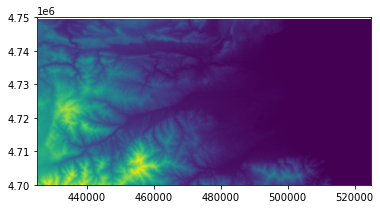

<AxesSubplot:>

In [43]:
# recherche du minimum, sur le masked array
min_value_msk = np.min(warped_values_msk)
print(min_value_msk)

# plot
show(warped_values_msk, transform=pretty_transform)

Comment présenter en noir les pixels avec une altitude <= 0 m. ? Avec une 2nde couche raster où les pixels > 0 m seraient masqués ! A voir dans un prochain chapitre ...

### Comment calculer les statistiques focales pixel par pixel ? (appliquer une fenêtre glissante)

Ce type de calcul implique l'utilisation du package **scipy**
Exemple : pour chaque pixel de notre MNT, nous souhaitons calcul la moyenne des pixels dans un rayon de 100 m.

Cela représente donc un rayon de 4 pixels (puisque la résolution du raster est de 25 mètres), dans une fenêtre de 9x9 pixels. Nous allons créer une matrice de poids de 9x9 éléments que nous utiliserons avec la fonction `convolve2d` du module scipy.signal. Attention cependant à la gestion des pixels situés sur les bords du raster : il manquera des pixels par rapport à la fenêtre à appliquer. La fonction `convolve2d` propose 3 façons de gérer les bords.

- _fill_ utilise une valeur de remplacement (0 par défaut) pour les pixels en dehors du raster
- _symm_ utilise les valeurs à l'intérieur du raster en miroir
- _wrap_ utilise les valeurs du bord opposé

Nous utiliserons ici 'symm'.

Commençons par définir une matrice de poids, avec des 1, et de forme circulaire.


In [44]:
# matrice distance par rapport au centre
def w_matrix_dist(n):
    r = (n - 1) / 2
    x = np.linspace(-r, r, n)
    y = np.linspace(-r, r, n)
    xx, yy = np.meshgrid(x, y)
    zz = np.sqrt(xx**2 + yy**2)
    return zz

# matrice distance de taille 9x9
dist_9x9 = w_matrix_dist(9)
# fenetre circulaire 9x9 : si r <=4 alors 1, sinon 0
circ_9x9 = np.where(dist_9x9 <= 4., np.ones_like(dist_9x9), np.zeros_like(dist_9x9))
circ_9x9

array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [45]:
# derniere étape pour créer la fenetre :
# la somme des elements doit etre = à 1 pour calculer la moyenne
circ_mean_9x9 = circ_9x9 / np.sum(circ_9x9)

In [49]:
%%time
from scipy import signal
rast_mean9x9 = signal.convolve2d(
    warped_values_msk, circ_mean_9x9, 
    boundary='symm', mode='same')
# note : attention les valeurs masquées (NoData, ici -9999)
# seront utilisées dans le calcul par la fonction convolve2d, 
# il faudra les masquer ainsi que leurs voisines dans les données en sortie ... 


CPU times: total: 1.27 s
Wall time: 1.27 s


#### Application : calcul de pente sur un MNT.

Un raster de pente peut être généré à partir d'un MNT en appliquant une fenêtre glissante de 3x3 pixels. 

Le détail du calcul est expliqué sur cette page : <https://pro.arcgis.com/fr/pro-app/2.8/tool-reference/spatial-analyst/how-slope-works.htm>. La pente est calculée comme le taux de variation (delta) de la surface dans les directions horizontale (dz/dx) et verticale (dz/dy) à partir de la cellule centrale vers chaque cellule adjacente.


In [50]:
%%time
# matrice de poids pour calculer dz/dx
w_dz_dx = np.array([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]])
w_dz_dx = np.array([[1., 0., -1.], [2., 0., -2.], [1., 0., -1.]])
# matrice de poids pour calculer dz/dy
w_dz_dy = np.array([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]])
w_dz_dy = np.array([[1., 2., 1.], [0., 0., 0.], [-1., -2., -1.]])
# resolution
res = 25.0

# calcul variation dans les directions horizontales
dz_dx = signal.convolve2d(
    warped_values_msk, np.flip(w_dz_dx), 
    boundary='fill', mode='same') / (res * 8.)
# calcul variation dans les directions verticales
dz_dy = signal.convolve2d(
    warped_values_msk, np.flip(w_dz_dy), 
    boundary='fill', mode='same') / (res * 8.)
# calcul pente en % 
rise_run = np.sqrt(dz_dx**2 + dz_dy**2)
# calcul pente en degrés
slope_degrees = np.arctan(rise_run) * (180 / np.pi)


CPU times: total: 578 ms
Wall time: 570 ms


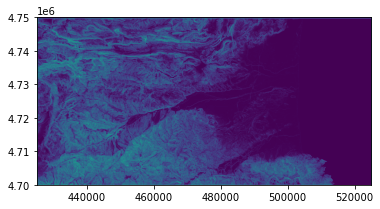

In [51]:
show(slope_degrees, transform=pretty_transform)

# sauvegarder raster pente degres en Geotiff : float32
slp_kwds = wrp_kwds.copy()
slp_kwds.update({
    'driver': "GTiff",
    'dtype': "float32",
    'nodata': -99.
})
f_output = join(d_output, 'pente_degres.tif')
with rasterio.open(f_output, 'w', **slp_kwds) as dst_dataset:
    dst_dataset.write(slope_degrees.astype(np.float32), 1)

TODO : éviter calcul sur les bords

### Comment lire ou écrire un raster bloc par bloc ?

Voir un exemple dans la 3ème partie.



## 3ème partie : interactions vecteur <-> raster<a class="anchor" id="partie-3"></a>

### Lecture de fichier Shapefile (interaction vecteur-raster)

Nous verrons comment appliquer des traitements sur des données vectorielles avec **geopandas** dans un autre notebook. Les lignes qui suivent sont uniquement destinées à ouvrir des données vectorielles pour les superposer au raster. 

In [52]:
%%time
# chemin d'acces aux shapefiles
f_communes = join(d_bdtopo, "ADMINISTRATIF","COMMUNE.shp")
gdf_communes = gpd.read_file(f_communes)
print(f"Nb enregistrements commune : {len(gdf_communes)}")


Nb enregistrements commune : 271
CPU times: total: 203 ms
Wall time: 221 ms


### Comment rastériser un shapefile ?

Pour rastériser un shapefile avec rasterio, la démarche est la suivante. Nous allons itérer sur les entités à graver dans le raster avec, à chaque itération, un couple de géométrie / valeur. La valeur correspondant à la forme est gravée dans un tableau numpy, il faut une valeur numérique. Il faut 

Il faut donc prévoir : 

- un itérateur sur des tuples (geométrie, valeur numérique)
- un tableau numpy qui servira de "modèle"
- une matrice de transformation ainsi que les caractéristiques du raster en sortie


Essayons de rastériser les communes sur l'étendue de notre MNT (rappel : nous utilisons la dalle BDALTIV2_25M_FXX_0650_6175_MNT_LAMB93_IGN69.asc). Nous reprenons l'étendue et la résolution du MNT. Nous obtiendrons un raster en sortie de 1000 x 1000 pixels, avec 25 m. de résolution.

Avant de procéder à la rastérisation, nous sélectionnons les polygones qui intersectent l'étendue du raster, pour optimiser le traitement. 

Pour cet exemple, nous choississons de graver le code commune INSEE (colonne 'INSEE_COM') du shapefile Commune. Cette colonne est de type texte : nous veillerons à convertir les valeurs en entier.



In [53]:
src_kwds = ds_mnt.meta
src_kwds

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 1000,
 'height': 1000,
 'count': 1,
 'crs': None,
 'transform': Affine(25.0, 0.0, 649987.5,
        0.0, -25.0, 6175012.5)}

CPU times: total: 62.5 ms
Wall time: 83.9 ms


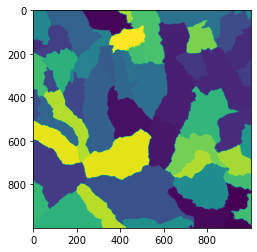

In [54]:
%%time
from rasterio import features

# copier metadonnees raster
dst_kwds = src_kwds.copy()
dst_kwds.update(
    nodata=0, 
    driver="GTiff",
    crs=CRS.from_epsg(2154), 
    dtype=rasterio.int32)

# avec cx, selectionnons les communes qui intersectent effectivement le MNT
bbox_mnt = ds_mnt.bounds
gdf_communes_mnt = gdf_communes.cx[
    bbox_mnt.left:bbox_mnt.right, bbox_mnt.bottom:bbox_mnt.top]

# iterateur sur (geometrie, valeur entier)
iter_communes = zip(gdf_communes_mnt.geometry, gdf_communes_mnt.INSEE_COM.astype(int))

# chemin fichier sortie
f_rasterized = join(d_output, 'rasterized_comm.tif')

# rasterisation !
with rasterio.open(f_rasterized, 'w', **dst_kwds) as dst_rasterized:
    burned = features.rasterize(
        iter_communes,
        transform=ds_mnt.transform,
        out_shape=ds_mnt.shape,
        dtype=np.int32
    )
    dst_rasterized.write(burned, 1) # write band 1
    plt.imshow(burned)


### Comment appliquer un masque ?

Nous allons utiliser la couche vectorielle COMMUNE.shp et plus particulièrement la commune de Prades comme masque, avec le module **mask** de rasterio. 

Nous appliquerons ce masque au raster MNT : les altitudes seront conservées à l'intérieur de la commune, tandis que l'extérieur du polygone sera masqué avec la valeur nodata.

Commençons par lire le shapefiles des communes du département, et cherchons la ligne correspondant à "Prades".

In [55]:
# filtrer : NOM == 'Prades'
feat1 = gdf_communes.query('NOM == "Prades"')
# feat1 est un objet de type GeoDataFrame avec 1 ligne
print(type(feat1))
print(len(feat1))

<class 'geopandas.geodataframe.GeoDataFrame'>
1


Il faut donner à la fonction `mask` une géométrie, ou bien un itérateur sur les géométries à masquer. Le paramètre `crop` indique si on veut découper le raster avec l'étendue de la commune. 

La fonction `mask`  renvoie un tableau numpy ainsi que la matrice de transformation correspondante.

In [56]:
from rasterio.mask import mask

# iterateur sur les geometries (polygones) à masquer 
iter_geom = feat1.geometry

# la fonction mask renvoie un tableau numpy, et une matrice de transform
dst_values, dst_transform = mask(ds_mnt, iter_geom, crop=True)

# copier et mettre à jour les propriétés du raster en sortie
dst_kwds = ds_mnt.meta.copy()
dst_kwds.update({
    "crs": CRS.from_epsg(2154),
    "driver": "GTiff",
    "height": dst_values.shape[1],
    "width": dst_values.shape[2],
    "transform": dst_transform
})

# création du raster en sortie avec le tableau 
f_mask_output = join(d_output, "mask_prades.tif")
with rasterio.open(f_mask_output, "w", **dst_kwds) as dest:
    dest.write(dst_values)

### Comment calculer des statistiques zonales ?

Le package **rasterstats** propose une fonction `zonal_stats` pour calculer les statistiques zonales d'un fichier raster sur les polygones d'une couche vecteur.

Par exemple, si vous souhaitons calculer l'altitude moyenne, minimale, médiane et le nombre de pixels de notre dalle de MNT pour les communes du département, la syntaxe la plus simple est de donner les noms du shapefile et du raster.

Le résultat est une liste de dictionnaires (chaque dictionnaire comprend les statistiques d'1 commune), facilement convertible en `DataFrame` pandas.

In [57]:
%%time
# rasterstats
import pandas as pd
from rasterstats import zonal_stats 
# fichiers utilisées
print(f_communes)
print(f_mnt)
# calcul zonal stats
result = zonal_stats(
    f_communes, f_mnt, stats="count min max median")
print("Nb éléments résultat :", len(result))
print(result[:4])
# convertir en DataFrame
df_result = pd.DataFrame(result)
df_result.head()

data\IGN\BDT_3-0_SHP_LAMB93_D066-ED2021-03-15\ADMINISTRATIF\COMMUNE.shp
data\IGN\BDALTIV2_MNT_25M_ASC_LAMB93_IGN69_D066\BDALTIV2_25M_FXX_0650_6175_MNT_LAMB93_IGN69.asc
Nb éléments résultat : 271
[{'count': 0, 'min': None, 'max': None, 'median': None}, {'count': 0, 'min': None, 'max': None, 'median': None}, {'count': 0, 'min': None, 'max': None, 'median': None}, {'count': 0, 'min': None, 'max': None, 'median': None}]
CPU times: total: 9.78 s
Wall time: 11 s


count         min         max      median
0      0         NaN         NaN         NaN
1      0         NaN         NaN         NaN
2      0         NaN         NaN         NaN
3      0         NaN         NaN         NaN
4  17616  298.600006  750.099976  375.200012

Comme les index du `GeoDataFrame` (shapefile communes) et du `DataFrame` (statistiques) correspondent, il est possible de faire une jointure.

In [64]:
# index des données
print(df_result.index)
print(gdf_communes.index)

# jointure
gdf_communes2 = gdf_communes.join(df_result)

# résultat de la jointure ? exemple avec Prades et Casteil
gdf_communes2.loc[
    gdf_communes2['NOM'].isin(['Campoussy', 'Casteil', 'Prades']), 
    ("NOM", "SURFACE_HA", "min", "max", "median", "count")
]

RangeIndex(start=0, stop=271, step=1)
RangeIndex(start=0, stop=271, step=1)


NOM  SURFACE_HA         min          max       median  count
4       Prades        1087  298.600006   750.099976   375.200012  17616
101  Campoussy        1704  976.700012  1014.700012  1005.900024     29
235    Casteil        2983  695.000000  2722.399902  1992.800049  42459

La fonction `zonal_stats` peut aussi recevoir un **itérateur sur des géométries** à la place du nom de fichier shapefile, et un **tableau numpy** (avec la transformation) à la place du nom de fichier raster.

In [60]:
%%time
# exemple zonal stats les données en mémoire : gdf_communes X ds_mnt
# avec uniquement les géométries des communes qui intersectent la dalle de mnt
gdf_communes_mnt = gdf_communes.cx[
    bbox_mnt.left:bbox_mnt.right, bbox_mnt.bottom:bbox_mnt.top]
result2 = zonal_stats(
    gdf_communes_mnt.geometry, 
    ds_mnt.read(1), affine=ds_mnt.transform, nodata=ds_mnt.nodata,
    stats="count min max median")
result2[:5]

CPU times: total: 188 ms
Wall time: 194 ms


[{'min': 298.6000061035156,
  'max': 750.0999755859375,
  'count': 17616,
  'median': 375.20001220703125},
 {'min': 162.77999877929688,
  'max': 785.0,
  'count': 23206,
  'median': 352.20001220703125},
 {'min': 285.3999938964844,
  'max': 781.5,
  'count': 12823,
  'median': 468.8999938964844},
 {'min': 354.6000061035156,
  'max': 616.2000122070312,
  'count': 1951,
  'median': 461.5899963378906},
 {'min': 194.17999267578125,
  'max': 369.8800048828125,
  'count': 12529,
  'median': 264.94000244140625}]

**Remarque** : de nombreuses communes sont situées en dehors du raster, ce qui fait qu'elles ont un nombre de pixel = 0, et des stats=NaN. Mais qu'en est-il des communes situées à la fois à l'intérieur et en dehors du raster ? 

On pourrait vérifier si les nombres de pixel (_count_) et la surface (*SURFACE_HA*) correspondent - sachant que 1 pixel = 0,0625 ha. Or dans l'exemple précédent, on voit qu'une petite partie de Campoussy seulement (29 pixels) a été utilisé pour les statistiques en sortie. 

Il faudrait donc, en toute rigueur, filtrer les communes inclues entièrement dans l'étendue du raster avant calculer les statistiques zonales.


## 4ème partie - application sur une image Sentinel 2<a class="anchor" id="partie-4"></a>

Voir notebook suivant.